# House price prediction calculator
## Created by Mohammed Thamim Ahmed

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib

import warnings

In [2]:
df = pd.read_csv("AmesHousing.csv")
print(df.info)
print(df.head())

<bound method DataFrame.info of       Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0         1  526301100           20        RL         141.0     31770   Pave   
1         2  526350040           20        RH          80.0     11622   Pave   
2         3  526351010           20        RL          81.0     14267   Pave   
3         4  526353030           20        RL          93.0     11160   Pave   
4         5  527105010           60        RL          74.0     13830   Pave   
...     ...        ...          ...       ...           ...       ...    ...   
2925   2926  923275080           80        RL          37.0      7937   Pave   
2926   2927  923276100           20        RL           NaN      8885   Pave   
2927   2928  923400125           85        RL          62.0     10441   Pave   
2928   2929  924100070           20        RL          77.0     10010   Pave   
2929   2930  924151050           60        RL          74.0      9627   Pave   

     Al

In [3]:
missing_values = df.isnull().sum().sort_values(ascending = False)
print(missing_values[missing_values > 0])

Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Mas Vnr Type      1775
Fireplace Qu      1422
Lot Frontage       490
Garage Cond        159
Garage Finish      159
Garage Yr Blt      159
Garage Qual        159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Qual           80
Bsmt Cond           80
BsmtFin Type 1      80
Mas Vnr Area        23
Bsmt Full Bath       2
Bsmt Half Bath       2
BsmtFin SF 1         1
Garage Cars          1
Electrical           1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
Garage Area          1
dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

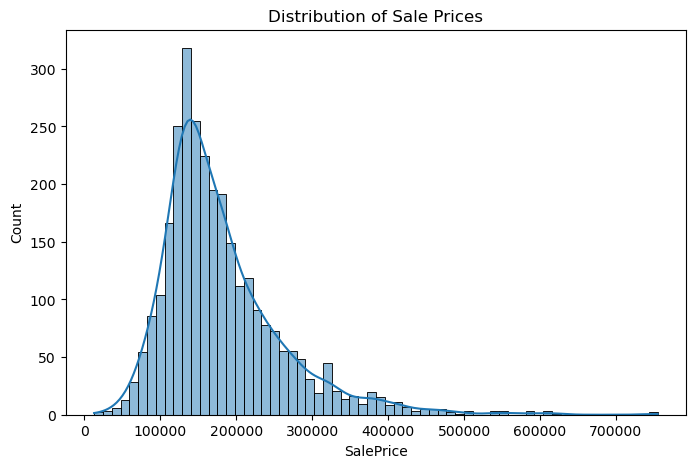

In [4]:
plt.figure(figsize=(8,5))
sns.histplot(df["SalePrice"],kde = True)
plt.title("Distribution of Sale Prices")
plt.show